In [1]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [2]:
# 1. Load Data
def load_data(data_dir):    
    images = []
    labels = []
    class_names = ['gesture']  # Generic label since there's only one gesture class

    img_paths = glob.glob(os.path.join(data_dir, '*.jpg'))  # Change to *.png if needed
    print(f"Found {len(img_paths)} images in the dataset.")  # Print number of images found

    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")  # Check if image loads correctly
            continue
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        img = img.astype("float32") / 255.0  # Normalize to [0, 1]
        images.append(img)
        labels.append(0)  # Assign a single label (0) since there's only one gesture class

    print(f"Number of images loaded: {len(images)}, Number of labels: {len(labels)}")
    return np.array(images), np.array(labels), class_names

data_dir = '/Users/sailajamorrennagari/Downloads/asl_alphabet_test'  # Update to your dataset path
X, y, class_names = load_data(data_dir)

Found 28 images in the dataset.
Number of images loaded: 28, Number of labels: 28


In [3]:
# 2. Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")


Training data shape: (19, 224, 224, 3), Test data shape: (9, 224, 224, 3)


In [4]:
# 3. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# 4. Build Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

In [6]:
# 5. Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])


In [7]:
# 6. Train Model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Changed to .keras
]

history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.6323 - val_accuracy: 1.0000 - val_loss: 1.3389e-25
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - accuracy: 1.0000 - loss: 1.2758e-24 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [8]:
# 7. Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 100.00%


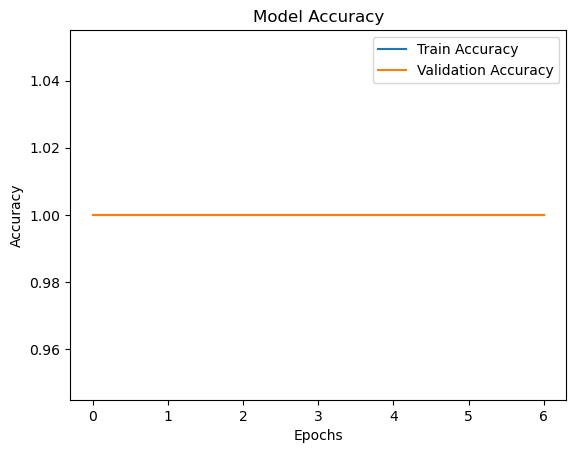

In [9]:
# 8. Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
              precision    recall  f1-score   support

     gesture       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



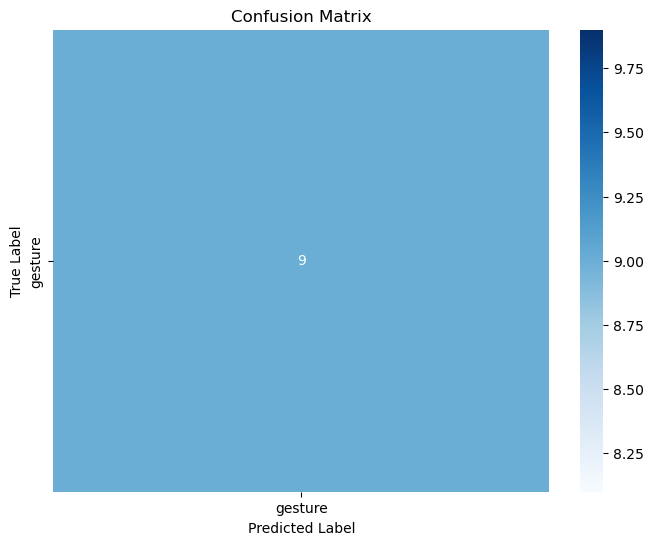

In [10]:
# 9. Confusion Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Binarize predictions
print(classification_report(y_test, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [11]:
# 10. Save the Final Model
model.save('final_gesture_model.keras')


In [13]:
# 11. Grad-CAM Visualization
def grad_cam(model, img, class_idx):
    # Get the last convolutional layer and output layer
    conv_layer_name = "top_conv"  # Use the last convolutional layer name
    dense_layer_name = "dense"  # The output layer name

    # Create a new model that outputs the last convolutional layer and predictions
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(dense_layer_name).output, model.get_layer(conv_layer_name).output]
    )

    with tf.GradientTape() as tape:
        preds, conv_outputs = grad_model(tf.convert_to_tensor(np.expand_dims(img, axis=0)))
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    # Check the shapes of the predictions and convolution outputs
    print("Predictions shape:", preds.shape)
    print("Convolutional outputs shape:", conv_outputs.shape)
    print("Gradients shape:", grads.shape)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap